<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_model_building_classification_option1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hybrid model
  This notebook is trying to build option-1 which includes classification followed by detection.

Classification:
  1. **ChexNet- Densnet121** - This has been implemented here.
  2. VGG NET
  3. InceptionV3
  4. InceptionRestNetV2

Detection:
  RetinaNet based architecture
  1. ResNet101 
  2. ResNet152

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "DenseNet121"
MODEL_NAME  = "Option-1" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 16
IMAGE_SIZE = 224 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
ALPHA = 1.0
EPOCHS = 2 

In [ ]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 88kB/s 
Setting baseModel : DenseNet121
<module 'tensorflow.keras.applications.densenet' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/densenet/__init__.py'>
global BaseModel; BaseModel =np.DenseNet121
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function DenseNet121 at 0x7fdd50f036a8> <function preprocess_input at 0x7fdd50f03840>


In [ ]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.densenet.DenseNet121>,
 <function tensorflow.python.keras.applications.densenet.preprocess_input>)

In [ ]:
MODEL_MAP[BASE_MODEL]['input_shape']


(224, 224, 3)

In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [ ]:

# CLASS_VECTORS = get_class_map(full_df)

In [ ]:
full_df.head(2)

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df,target='class')

(18678, 14) training data
(8006, 14) raw validation data
(4003, 14) Validation data
(4003, 14) test data


In [ ]:
unbalanced_train_df[unbalanced_train_df.class_id == 0].shape[0]

4208

12624 Final training size


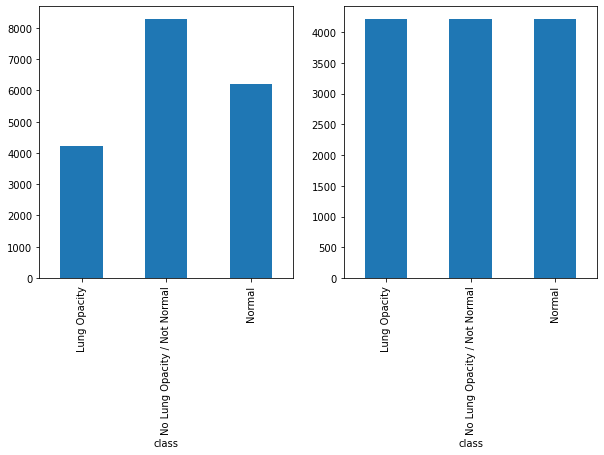

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 12624 # 4208 x 3 class targets
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES,target='class')
print(train_df.shape[0], 'Final training size')

## Build model

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

12624

In [ ]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyLabelDataGenerator(train_df)
valid_gen = MyLabelDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

12624 :No of generator Image
4003 :No of generator Image
789 # of iterations in one train epoch
250 # of iterations in one validate epoch


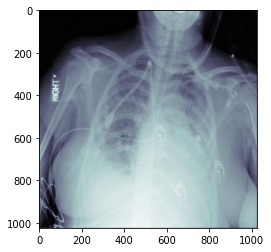

In [ ]:
path = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('path')
img = train_gen.getImage(path)
plt.imshow(img, cmap=plt.cm.bone)

In [ ]:
imageSet = train_gen[9][0]
maskSet = train_gen[9][1]   #Label

In [ ]:
imageSet.shape,maskSet.shape

((16, 224, 224, 3), (16, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


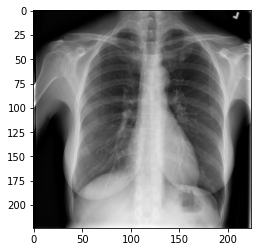

In [ ]:
plt.imshow(imageSet[9], cmap=plt.cm.bone)

In [ ]:

def build_pretrained_model():
  #Build base model
  input_shape = MODEL_MAP[BASE_MODEL]['input_shape']
  base_pretrained_model = BaseModel(input_shape =  input_shape, 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False
  #Build Top layer
  lastlayer = MODEL_MAP[BASE_MODEL]['last_conv_layer']
  lastlayershape = base_pretrained_model.get_layer(lastlayer).output_shape[1:]
  pt_features = Input(lastlayershape, name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'top_model')
  #Combine base & top model
  pneu_model = Sequential(name = 'combined_model')
  # base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  #Add loss & optimizer
  lr = LEARN_RATE
  decay = lr/10 # or in the factor of 10
  adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
  pneu_model.compile(optimizer =adamOptimizer, loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model,base_pretrained_model,attn_model

In [ ]:
class_model,base_model,top_model = build_pretrained_model()
class_model.summary()

Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
top_model (Functional)       (None, 3)                 136067    
Total params: 7,173,571
Trainable params: 133,763
Non-trainable params: 7,039,808
_________________________________________________________________


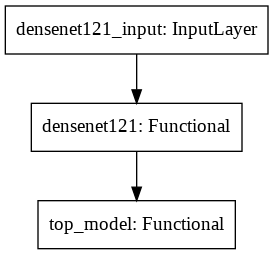

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(class_model)

In [ ]:
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Model Fit

In [ ]:

history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  class_model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    class_model.load_weights(WEIGHTS_FILE)
  history = class_model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=callbacks_list,
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

## History

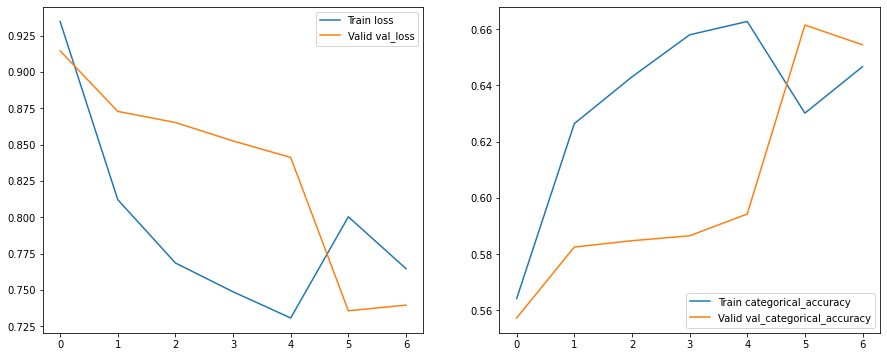

In [ ]:
plot_his(history,'categorical_accuracy')
#Save the model as well for future use

## Classification-Stage1 performance

In [ ]:
predict_gen = MyLabelTestDataGenerator(train_df)

12624 :No of generator Image


In [ ]:
patients, pred_Y,valid_Y = class_predict(predict_gen,class_model,no_of_batch=0)

100%|██████████| 789/789 [04:28<00:00,  2.94it/s]


                              precision    recall  f1-score   support

                Lung Opacity       0.70      0.71      0.71      4208
No Lung Opacity / Not Normal       0.61      0.47      0.53      4208
                      Normal       0.73      0.88      0.80      4208

                    accuracy                           0.69     12624
                   macro avg       0.68      0.69      0.68     12624
                weighted avg       0.68      0.69      0.68     12624



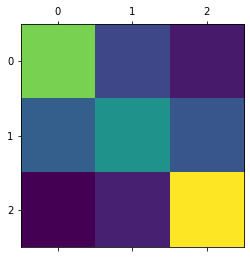

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

### ROC AUC

In [ ]:
type(valid_Y[0])

numpy.ndarray

In [ ]:
np.argmax(valid_Y,-1)==0

array([ True,  True, False, ..., False, False, False])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'DenseNet1 (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

ValueError: ignored

## Generate class prediction

In [ ]:
pred_df = get_prediction_map(patients,pred_Y)

In [ ]:
pred_df.reset_index(inplace=True)
# pred_df.columns = ['patientId', 'PNEUMONIA', 'NOT_NORMAL', 'NORMAL']

pred_df.rename(columns={'index':'patientId'},inplace=True)
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,1620067b-02c9-4f3d-9b49-a1b7f6f77358,0.845068,0.150875,0.004058
1,8142655b-0c33-40c2-a873-e504651431bc,0.773802,0.222809,0.003389
2,60e569c0-cc9d-48b3-b554-c871e3107665,0.005411,0.024865,0.969724
3,31559539-9087-4bd0-806a-30413a980cf1,0.079002,0.290347,0.630651
4,9d487748-1f51-48aa-afdc-a6225be8bdba,0.099067,0.263003,0.637930


In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   12624 non-null  object 
 1   PNEUMONIA   12624 non-null  float64
 2   NOT_NORMAL  12624 non-null  float64
 3   NORMAL      12624 non-null  float64
dtypes: float64(3), object(1)
memory usage: 394.6+ KB


In [ ]:
#Dump the prediction as it is very time consuming task.
pred_dump_file = MODEL_NAME + '/class_prediction.csv'
import pandas as pd
pred_df = pd.DataFrame()
if (os.path.isfile(pred_dump_file)):
  pred_df = pd.read_csv(pred_dump_file)
else:
  pred_df.to_csv(pred_dump_file)

In [ ]:
# pred_df.drop(pred_df.columns[0],inplace=True,axis=1)

In [ ]:
merged_pred_meta_df = get_pred_merged_meta_data(pred_df,full_df)
merged_pred_meta_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
1620067b-02c9-4f3d-9b49-a1b7f6f77358,0.845068,0.150875,0.004058,50.0,0.0,1.0,1.0
8142655b-0c33-40c2-a873-e504651431bc,0.773802,0.222809,0.003389,72.0,0.0,1.0,1.0
60e569c0-cc9d-48b3-b554-c871e3107665,0.005411,0.024865,0.969724,54.0,0.0,0.0,0.0
31559539-9087-4bd0-806a-30413a980cf1,0.079002,0.290347,0.630651,26.0,0.0,1.0,0.0
9d487748-1f51-48aa-afdc-a6225be8bdba,0.099067,0.263003,0.637930,54.0,1.0,0.0,0.0


In [ ]:
merged_pred_meta_df.reset_index(inplace=True)
merged_pred_meta_df.rename(columns={'index':'patientId'},inplace=True)
merged_pred_meta_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
0,1620067b-02c9-4f3d-9b49-a1b7f6f77358,0.845068,0.150875,0.004058,50.0,0.0,1.0,1.0
1,8142655b-0c33-40c2-a873-e504651431bc,0.773802,0.222809,0.003389,72.0,0.0,1.0,1.0
2,60e569c0-cc9d-48b3-b554-c871e3107665,0.005411,0.024865,0.969724,54.0,0.0,0.0,0.0
3,31559539-9087-4bd0-806a-30413a980cf1,0.079002,0.290347,0.630651,26.0,0.0,1.0,0.0
4,9d487748-1f51-48aa-afdc-a6225be8bdba,0.099067,0.263003,0.637930,54.0,1.0,0.0,0.0


In [ ]:
merged_pred_meta_df[merged_pred_meta_df.Target==1].sample(5)

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
10970,640743e2-59ed-4859-b25b-eb92f351cef0,0.105012,0.560435,0.334553,24.0,1.0,0.0,1.0
7972,56b6f280-7857-4623-8f9d-4f0c69dc71a6,0.631119,0.327929,0.040952,34.0,1.0,1.0,1.0
3167,2139214a-4a50-4144-9c2d-eb4c929e1e7e,0.889976,0.107431,0.002593,29.0,1.0,1.0,1.0
5385,ef0fe9c2-fb59-4631-86ec-c47020ff231b,0.900668,0.098536,0.000796,54.0,0.0,1.0,1.0
11946,55521950-18eb-4dd0-abc3-52e52466fcdb,0.639033,0.337617,0.023350,46.0,0.0,1.0,1.0


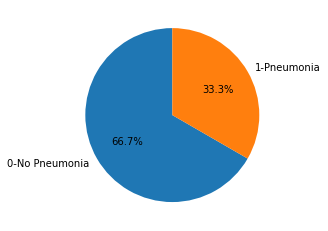

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unique_values, count = np.unique(merged_pred_meta_df['Target'], return_counts=True)

plt.pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()
#Need to balance the data here.

In [ ]:
#Split the data into train & valid
y = merged_pred_meta_df['Target'].to_numpy()
X = merged_pred_meta_df[merged_pred_meta_df.columns[1:7]]

In [ ]:
X.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition
0,0.845068,0.150875,0.004058,50.0,0.0,1.0
1,0.773802,0.222809,0.003389,72.0,0.0,1.0
2,0.005411,0.024865,0.969724,54.0,0.0,0.0
3,0.079002,0.290347,0.630651,26.0,0.0,1.0
4,0.099067,0.263003,0.637930,54.0,1.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## FFNN model

In [ ]:
#Build neural netwrok

from tensorflow.keras.layers import  Reshape
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  # model.add(Reshape((6,),input_shape=(32,32,)))
  # #Add batch normalization to avoid NAN in training loss
  # model.add(kl.normalization.BatchNormalization())
  #Add input layer -- 
  model.add(Dense(6,input_dim= 6,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [ ]:
def fit_model(opt,model,epoch=60,verbo=1,batchsize=128):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
history = fit_model(opt,nn_model)

Epoch 1/60
89/89 [==============================] - 1s 7ms/step - loss: 0.7334 - accuracy: 0.5508 - val_loss: 0.8084 - val_accuracy: 0.5970
Epoch 2/60
89/89 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5815 - val_loss: 0.7089 - val_accuracy: 0.5273
Epoch 3/60
89/89 [==============================] - 0s 5ms/step - loss: 0.6659 - accuracy: 0.6043 - val_loss: 0.7101 - val_accuracy: 0.5297
Epoch 4/60
89/89 [==============================] - 0s 5ms/step - loss: 0.6310 - accuracy: 0.6374 - val_loss: 0.6578 - val_accuracy: 0.5946
Epoch 5/60
89/89 [==============================] - 0s 5ms/step - loss: 0.5940 - accuracy: 0.6789 - val_loss: 0.6032 - val_accuracy: 0.6857
Epoch 6/60
89/89 [==============================] - 0s 5ms/step - loss: 0.5600 - accuracy: 0.7169 - val_loss: 0.6051 - val_accuracy: 0.6730
Epoch 7/60
89/89 [==============================] - 0s 5ms/step - loss: 0.5342 - accuracy: 0.7571 - val_loss: 0.6721 - val_accuracy: 0.6041
Epoch 8/60
89/89 [==

In [ ]:
HISTORY_FILE = MODEL_NAME+"/" +"history_FFNN.csv"
his_ffnn = saveHistory(history,HISTORY_FILE)

## Classification Performance(Recall)

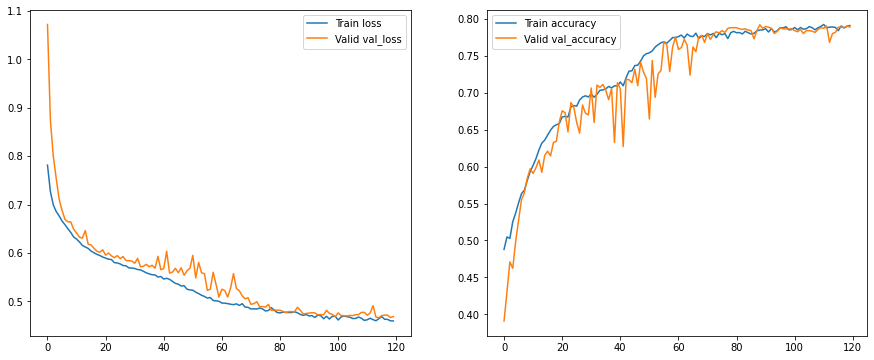

In [ ]:
plot_his(his_ffnn,'accuracy')

In [ ]:
pred_y = nn_model.predict(X_test)

In [ ]:
pred_y

array([[0.07833574],
       [0.04031   ],
       [0.57292855],
       ...,
       [0.07269049],
       [0.06386518],
       [0.61263716]], dtype=float32)

In [ ]:
pred_y_class = (pred_y >= 0.45).astype(np.int)

In [ ]:
y_test = (y_test >= 0.5).astype(np.int)


In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, pred_y_class), "\n")
print("Classification Report:- \n", metrics.classification_report(y_test, pred_y_class))

Confusion Matrix:- 
 [[704 135]
 [120 304]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       839
           1       0.69      0.72      0.70       424

    accuracy                           0.80      1263
   macro avg       0.77      0.78      0.78      1263
weighted avg       0.80      0.80      0.80      1263



### ROC curve

Text(0.5, 1.0, 'Lung Opacity ROC Curve')

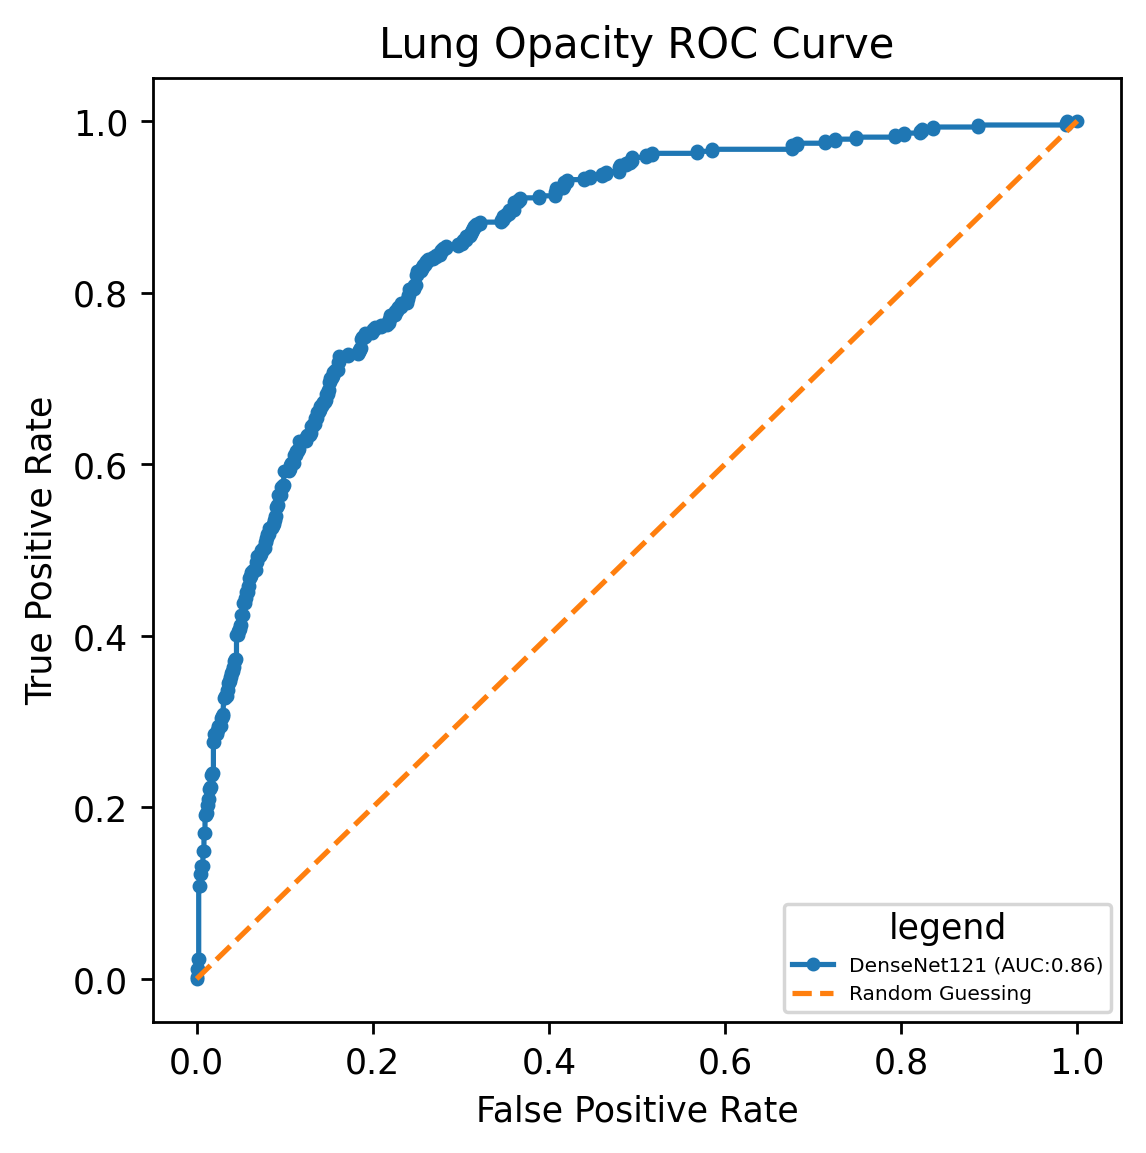

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, marker='.', label = 'DenseNet121 (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right', prop=fontP)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

## Conclusion